# Comparision of coustume LSTM model, state of the art MarianMT  


In this notebook, we compare the performance of a customized LSTM translator model with the state of the art pre-trained model loaded from the hugging face and fine-tuned on our dataset. Taking advantage from the Anki dataset, we train the customized LSTM translator and fine tune the

"Helsinki-NLP/opus-mt-de-en" model  which is a pre-trained neural machine translation (NMT) model that is part of the Opus-MT project, which provides a collection of pre-trained machine translation models for multiple language pairs.

As the "de-en" in the model name indicates that it is a model trained to translate from German (de) to English (en). The model is based on a transformer architecture and was trained on a large corpus of German and English text using the open-source Hugging Face Transformers library.


To evaluate the performance of both models, we use the

'sentence_bleu' which is a function from the Natural Language Toolkit package that computes the sentence-level BLEU score between a candidate sentence and a set of reference sentences. BLEU is a popular way to measure the quality of machine translation output.

The BLEU score measures the degree of similarity between the candidate sentence and one or more reference sentences based on their n-gram overlap. The function computes the BLEU score for a single candidate sentence and a reference sentence.

We train both models on the 5000 sentence pairs from the de-en Anki dataset in order to obtain short running time for executing the codes in this notebook. However this results in very low performance of our custumized LSTM translator.

## Import the packages and seting constant values

In [81]:
# import necessary libraries 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector, SimpleRNN
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.utils import pad_sequences
from keras.models import load_model
from tensorflow.keras import optimizers
from time import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
import json

## Loading, preprocessing, and splitting the data into train, test and validation pairs

In [92]:
# Load the English-German sentence pairs from anki dataset, shuffle and load the 5000 rows to train, test and validate the models
#update the path if necessary
path = "../Translator/deu-eng/deu.txt"
sentence_pairs = pd.read_csv(path ,sep='\t',names=["en", "de", "Remark"]).drop('Remark', axis=1).sample(frac=1, random_state=123).iloc[:5000]

In [4]:
# Remove special characters and punctuation and transform sentences into lower case
sentence_pairs["en"] = sentence_pairs['en'].str.lower().replace('[^\w\s]','', regex = True)
sentence_pairs["de"] = sentence_pairs['de'].str.lower().replace('[^\w\s]','', regex = True)

sentence_pairs.head()

,en,de
176581,i wont be at the opening ceremony,ich werde an der eröffnungszeremonie nicht tei...
228059,tom didnt want mary to babysit his children,tom wollte nicht dass maria auf seine kinder a...
175992,i havent given it any thought yet,darüber habe ich mir noch keine gedanken gemacht
224728,tom and mary admired the landscape together,tom und maria bewunderten zusammen die landschaft
85804,ill do whatever you ask,ich werde alles tun was du verlangst


In [41]:
# Split data into train validation and test 
train_size = int(len(sentence_pairs) * 0.8)
test_val_size =  int(len(sentence_pairs) * 0.1)

df_train = sentence_pairs.iloc[: train_size]
df_val = sentence_pairs.iloc[train_size: train_size+test_val_size]
df_test = sentence_pairs.iloc[train_size+test_val_size : ]

# Convert train, test, validation of English and German to list
en_train, de_train = df_train["en"], df_train["de"]
en_val, de_val = df_val["en"], df_val["de"]
en_test, de_test = df_test["en"], df_test["de"]

4000 4000
500 500
500 500


# Customized LSTM translator 

In [42]:
from keras.preprocessing.text import Tokenizer

# create tokenizer for English and fit on sentence_pairs["en"]
en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(sentence_pairs["en"])

#create tokenizer for German and fit on sentence_pairs["de"]
de_tokenizer = Tokenizer()
de_tokenizer.fit_on_texts(sentence_pairs["de"])

#get the number of unique English and German words
en_words = len(en_tokenizer.word_index) + 1
de_words = len(de_tokenizer.word_index) + 1

In [44]:
# Function to convert senteces to vectors
def convert_to_vectors(tokenizer, max_length, sents):
    sequences = tokenizer.texts_to_sequences(sents)
    text = pad_sequences(sequences, maxlen=max_length)
    return text

In [45]:
from keras.preprocessing.text import text_to_word_sequence

#maximum sequence size - English
max_len_en = max([len(text_to_word_sequence(x)) for x in sentence_pairs["en"]])

#maximum sequence size - German
max_len_de = max([len(text_to_word_sequence(x)) for x in sentence_pairs["de"]])

print(max_len_en, max_len_de)

23 27


In [46]:
#convert English and German training and test data to vectors
en_train_vec = convert_to_vectors(en_tokenizer, max_len_en, en_train).astype("float32")
de_train_vec = convert_to_vectors(de_tokenizer, max_len_de, de_train).astype("float32")


en_test_vec = convert_to_vectors(en_tokenizer, max_len_en, en_test).astype("float32")
de_test_vec = convert_to_vectors(de_tokenizer, max_len_de, de_test).astype("float32")

In [88]:
#set parameters
in_vocab = de_words # German vocab size 
out_vocab = en_words # English vocab size
in_timesteps = max_len_de # Length of the input sequence  
out_timesteps = max_len_en # Length of the output sequence
learning_rate = 0.001 # Learning rate
epochs = 32


In [48]:
#create LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(in_vocab, 512, input_length=in_timesteps, mask_zero=True))
lstm_model.add(LSTM(512, go_backwards = True)) 
lstm_model.add(RepeatVector(out_timesteps))
lstm_model.add(LSTM(512, return_sequences=True))
lstm_model.add(Dense(out_vocab, activation="softmax"))

#compile the model with optimizer, loss function, and metrics               
adam = optimizers.Adam(learning_rate=learning_rate)
lstm_model.compile(optimizer=adam, loss="sparse_categorical_crossentropy",metrics=["accuracy"])
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 27, 512)           2463232   
                                                                 
 lstm_2 (LSTM)               (None, 512)               2099200   
                                                                 
 repeat_vector_1 (RepeatVect  (None, 23, 512)          0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 23, 512)           2099200   
                                                                 
 dense_1 (Dense)             (None, 23, 3414)          1751382   
                                                                 
Total params: 8,413,014
Trainable params: 8,413,014
Non-trainable params: 0
____________________________________________

In [49]:
#train the model on the training data and validate on the test data
history = lstm_model.fit(de_train_vec, 
                         en_train_vec.reshape(en_train_vec.shape[0], en_train_vec.shape[1], 1),
                         epochs=epochs, 
                         batch_size=512, #neurons
                         validation_data=(de_test_vec, en_test_vec.reshape(en_test_vec.shape[0], en_test_vec.shape[1], 1)), 
                         verbose=1)


Epoch 1/32
8/8 [==============================] - 34s 3s/step - loss: 6.8983 - accuracy: 0.6327 - val_loss: 3.3337 - val_accuracy: 0.7208
Epoch 2/32
8/8 [==============================] - 20s 2s/step - loss: 2.7863 - accuracy: 0.7252 - val_loss: 2.5754 - val_accuracy: 0.7208
Epoch 3/32
8/8 [==============================] - 20s 2s/step - loss: 2.4180 - accuracy: 0.7252 - val_loss: 2.4564 - val_accuracy: 0.7208
Epoch 4/32
8/8 [==============================] - 20s 2s/step - loss: 2.3349 - accuracy: 0.7252 - val_loss: 2.4026 - val_accuracy: 0.7208
Epoch 5/32
8/8 [==============================] - 20s 3s/step - loss: 2.3009 - accuracy: 0.7252 - val_loss: 2.3881 - val_accuracy: 0.7208
Epoch 6/32
8/8 [==============================] - 20s 3s/step - loss: 2.2787 - accuracy: 0.7252 - val_loss: 2.3670 - val_accuracy: 0.7208
Epoch 7/32
8/8 [==============================] - 21s 3s/step - loss: 2.2561 - accuracy: 0.7249 - val_loss: 2.3455 - val_accuracy: 0.7208
Epoch 8/32
8/8 [==================

In [87]:
# Create new dataset for comparison
predictions = np.argmax(lstm_model.predict(de_test_vec.reshape(de_test_vec.shape[0], de_test_vec.shape[1], 1)), axis=-1)

#get the predictions on the test data and convert them to texts
lstm_prediction = en_tokenizer.sequences_to_texts(predictions)

#create a dataframe with the input sentence
result = pd.DataFrame({"input" : de_test, "actual" : en_test, "lstm_prediction" : lstm_prediction})

result

16/16 [==============================] - 2s 123ms/step


,input,actual,lstm_prediction
193956,du hast es zu früh aus dem ofen geholt,you took it out of the oven too soon,to to to to to
40774,es friert wieder,its freezing again,
214627,kinder sollten kind sein dürfen,children should be allowed to be children,to to to
153323,es ist offensichtlich dass tom gelogen hat,its obvious that tom was lying,to to to to
196436,ist das ihr erster besuch dieser stadt,is this your first visit to this town,to to to to
...,...,...,...
2742,ich bin beliebt,im popular,
242060,das restaurant liegt auf der dem hotel gegenüb...,the restaurant is across the street from the h...,to to to to to
98885,tom hat seine autoschlüssel verloren,tom has lost his car keys,
175799,ich glaube nicht dass sie französisch spricht,i dont think she can speak french,to to to to


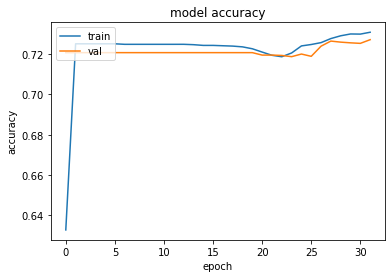

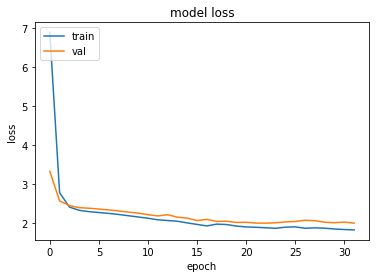

In [85]:
# Plot validation and train loss per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

After studying the loss and accuracy based on the number of epochs, we can conclude that the model does not learn well. We also observe that the predicted translation is far from the actual sentences. I should mention that this could be due to the relatively small data set we used, however, even increasing the number of sentence pairs to 50000 and 100000 did not improve the translations.

# Fine Tuned model

In order to learn how to fine tune the model loaded from the hugging face API, I have read the instructions on the hugging face website, instructions on how to fine tune a translator, and the following notebook. https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb

In [21]:
from datasets import Dataset, load_metric
# Create a dictionary from the train, test, and validation dataframes
# where each row is a dictionary of column names and values
test_dict = {'translation': df_test.to_dict('records')}
train_dict = {'translation': df_train.to_dict('records')}
val_dict = {'translation': df_val.to_dict('records')}

# Convert the dictionaries into datasets using the Hugging Face Datasets library
dataset_train = Dataset.from_dict(train_dict)
dataset_test = Dataset.from_dict(test_dict)
dataset_val = Dataset.from_dict(val_dict)

# Load the sacreBLEU metric for evaluation
metric = load_metric("sacrebleu")

/tmp/ipykernel_543020/1763702068.py:14: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("sacrebleu")


In [23]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, AutoTokenizer
# Load the pre-trained model and tokenizer from the Hugging Face model hub
model_checkpoint = "Helsinki-NLP/opus-mt-de-en"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# Create a data collator that will process the data into batches for the model
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

/home/niloofar/.local/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:198: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [24]:
# Set the maximum input and target sequence lengths and source/target languages
max_input_length = 128
max_target_length = 128
source_lang = "de"
target_lang = "en"

# Define a function to preprocess the data into model inputs and labels
def preprocessn(data):
    inputs = [ dt["de"] for dt in data["translation"]]
    targets = [df["en"] for dt in data["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)
    
    # Set the model inputs labels to the tokenized target sequences
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenize the datasets using the preprocess function and the Hugging Face Datasets library
tokenized_datasets_train = dataset_train.map(preprocessn, batched=True)
tokenized_datasets_test = dataset_test.map(preprocessn, batched=True)
tokenized_datasets_val = dataset_val.map(preprocessn, batched=True)

In [26]:
# Set the model name and training arguments for the Seq2SeqTrainer
model_name = 'Niloofar_Rahmati'
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-{source_lang}-to-{target_lang}",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=4,
    predict_with_generate=True,
    logging_steps=16,
    eval_steps=16,
    overwrite_output_dir=True,

)

/home/niloofar/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [27]:
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)


    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]
    
    # Compute the sacreBLEU metric
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    return result

In [28]:
# Train the fine tune model
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_val,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

The following columns in the training set don't have a corresponding argument in `MarianMTModel.forward` and have been ignored: translation. If translation are not expected by `MarianMTModel.forward`,  you can safely ignore this message.
/home/niloofar/.local/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4000
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 500


Epoch,Training Loss,Validation Loss,Bleu
1,0.771500,0.701484,53.910564
2,0.567400,0.673973,55.509419
3,0.533500,0.666490,54.842037
4,0.430400,0.665918,55.626350


The following columns in the evaluation set don't have a corresponding argument in `MarianMTModel.forward` and have been ignored: translation. If translation are not expected by `MarianMTModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `MarianMTModel.forward` and have been ignored: translation. If translation are not expected by `MarianMTModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `MarianMTModel.forward` and have been ignored: translation. If translation are not expected by `MarianMTModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 64
Saving model checkpoint to Niloofar_Rahmati-finetuned-de-to-en/checkpo

TrainOutput(global_step=500, training_loss=0.6284736833572387, metrics={'train_runtime': 1055.9162, 'train_samples_per_second': 15.153, 'train_steps_per_second': 0.474, 'total_flos': 79195055063040.0, 'train_loss': 0.6284736833572387, 'epoch': 4.0})

In [29]:
# Save the model
trainer.save_model(output_dir='../Translator/Niloofar_Rahmati-finetuned-de-to-en/')

Saving model checkpoint to ../Translator/Niloofar_Rahmati-finetuned-de-to-en/
Configuration saved in ../Translator/Niloofar_Rahmati-finetuned-de-to-en/config.json
Model weights saved in ../Translator/Niloofar_Rahmati-finetuned-de-to-en/pytorch_model.bin
tokenizer config file saved in ../Translator/Niloofar_Rahmati-finetuned-de-to-en/tokenizer_config.json
Special tokens file saved in ../Translator/Niloofar_Rahmati-finetuned-de-to-en/special_tokens_map.json


In [39]:
# Load fine tuned model from local
from tqdm import tqdm
nil_model = AutoModelForSeq2SeqLM.from_pretrained('../Translator/Niloofar_Rahmati-finetuned-de-to-en/')
tokenizer_niloo = AutoTokenizer.from_pretrained('../Translator/Niloofar_Rahmati-finetuned-de-to-en/')

examples = de_test.to_list()
translated = nil_model.generate(**tokenizer_trf(examples, return_tensors="pt",max_length=512, padding=True, verbose=1))
predictions_niloo = [tokenizer_niloo.decode(t, skip_special_tokens=True) for t in tqdm(translated)]

Didn't find file ../Translator/Niloofar_Rahmati-finetuned-de-to-en/target_vocab.json. We won't load it.
Didn't find file ../Translator/Niloofar_Rahmati-finetuned-de-to-en/added_tokens.json. We won't load it.
loading file ../Translator/Niloofar_Rahmati-finetuned-de-to-en/source.spm
loading file ../Translator/Niloofar_Rahmati-finetuned-de-to-en/target.spm
loading file ../Translator/Niloofar_Rahmati-finetuned-de-to-en/vocab.json
loading file None
loading file ../Translator/Niloofar_Rahmati-finetuned-de-to-en/tokenizer_config.json
loading file None
loading file ../Translator/Niloofar_Rahmati-finetuned-de-to-en/special_tokens_map.json
100%|███████████████████████████████████████| 500/500 [00:00<00:00, 4654.69it/s]


In [82]:
result = pd.DataFrame({'input' : de_test, 'actual' : en_test, 'lstm_prediction' : lstm_prediction, 'finetune_prediction': predictions_niloo})
result

,input,actual,lstm_prediction,finetune_prediction
193956,du hast es zu früh aus dem ofen geholt,you took it out of the oven too soon,to to to to to,you got it out of the oven too soon
40774,es friert wieder,its freezing again,,it freezes again
214627,kinder sollten kind sein dürfen,children should be allowed to be children,to to to,children should be allowed to be children
153323,es ist offensichtlich dass tom gelogen hat,its obvious that tom was lying,to to to to,its obvious that tom lied
196436,ist das ihr erster besuch dieser stadt,is this your first visit to this town,to to to to,is this your first visit to this city
...,...,...,...,...
2742,ich bin beliebt,im popular,,im popular
242060,das restaurant liegt auf der dem hotel gegenüb...,the restaurant is across the street from the h...,to to to to to,the restaurant is on the opposite side of the ...
98885,tom hat seine autoschlüssel verloren,tom has lost his car keys,,tom lost his car keys
175799,ich glaube nicht dass sie französisch spricht,i dont think she can speak french,to to to to,i dont think she speaks french


# Evaluating our models

To evaluate the translation provided by the customized LSTM model and the fine-tuned model, we calculated the BLEU score for sentence pairs, meaning that we compare the output of a machine translation system to one or more human translations of the same input using this score.

The similarity between machine-generated text and the reference translation is measured by counting how many n-grams (contiguous sequences of n words) in the machine-generated text appear in the reference translation.

In [70]:
from nltk.translate.bleu_score import sentence_bleu

def calc_bleu(ref, hyp):
    ref = ref.split(" ")
    hyp = hyp.split(" ")
    score = sentence_bleu([ref], hyp)
    return score

Below, we compare the calculated BLEU score for the sentence pairs and the actual English sentence with the predicted translations. We see that our fine-tuned model performs much better than our current customized LSTM model, which can be further improved.

In [90]:
result["bleu_lstm"] = pred_df.apply(lambda x: calc_bleu(x["actual"], x["lstm_prediction"]), axis=1)
result["bleu_finetune"] = pred_df.apply(lambda x: calc_bleu(x["actual"], x["finetune_prediction"]), axis=1)

result.head(30)

/home/niloofar/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/niloofar/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/niloofar/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use Smoo

,input,actual,lstm_prediction,bleu_lstm,bleu_finetune
193956,du hast es zu früh aus dem ofen geholt,you took it out of the oven too soon,to to to to to,0.000000e+00,7.506239e-01
40774,es friert wieder,its freezing again,,0.000000e+00,1.384293e-231
214627,kinder sollten kind sein dürfen,children should be allowed to be children,to to to,3.648957e-232,1.000000e+00
153323,es ist offensichtlich dass tom gelogen hat,its obvious that tom was lying,to to to to,0.000000e+00,5.475183e-01
196436,ist das ihr erster besuch dieser stadt,is this your first visit to this town,to to to to,4.739132e-232,8.408964e-01
217822,tom kann noch nicht gut flöte spielen,tom still isnt good at playing the flute,to to to to,0.000000e+00,6.373704e-155
15019,tom glaubte mir,tom believed me,,0.000000e+00,1.221339e-77
190487,jetzt ist tom an der reihe fragen zu stellen,its now toms turn to ask questions,to to to to to to,9.853445e-232,4.335118e-78
203675,tom sieht überhaupt nicht wie ein lehrer aus,tom doesnt seem like a teacher at all,to to to to,0.000000e+00,5.946036e-01
179020,tom hat herausgefunden wie man die kiste öffnet,tom discovered how to open the box,to to to to to,8.166727e-232,5.410823e-01
